In [2]:
import numpy as np
import pandas as pd

In [3]:


def make_windows_for_p(ds, p):
    """
    ds: dict with X [N,T], A [N,T,p_max], p_true [N]
    returns:
      Z: [M, p]      lag vectors
      y: [M]         targets x_t
      a_true_p: [M,p] true coeffs at time t for first p lags (padded ones are already 0)
      sid: [M]       trajectory id
      t_idx: [M]     time index
    """
    X = ds["X"]
    A = ds["A"]
    N, T = X.shape
    p_max = A.shape[2]
    assert p <= p_max, f"p={p} > p_max={p_max} in dataset"

    M_per = T - p
    M = N * M_per

    Z = np.zeros((M, p), dtype=np.float32)
    y = np.zeros((M,), dtype=np.float32)
    a_true_p = np.zeros((M, p), dtype=np.float32)
    sid = np.zeros((M,), dtype=np.int64)
    t_idx = np.zeros((M,), dtype=np.int64)

    idx = 0
    for i in range(N):
        x = X[i]
        for t in range(p, T):
            Z[idx] = x[t-p:t][::-1]           # [x_{t-1},...,x_{t-p}]
            y[idx] = x[t]
            a_true_p[idx] = A[i, t, :p]       # first p coeffs at time t
            sid[idx] = i
            t_idx[idx] = t
            idx += 1

    return Z, y, a_true_p, sid, t_idx

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

class MLPCoeffAR(nn.Module):
    """
    Input: Z_s [B,p]
    Output: coeffs_s [B,p], bias_s [B]
    Prediction: yhat_s = <coeffs_s, Z_s> + bias_s
    """
    def __init__(self, p, hidden=128, depth=3, dropout=0.05):
        super().__init__()
        layers = []
        in_dim = p
        for _ in range(depth):
            layers += [
                nn.Linear(in_dim, hidden),
                nn.GELU(),
                nn.LayerNorm(hidden),
                nn.Dropout(dropout),
            ]
            in_dim = hidden
        self.backbone = nn.Sequential(*layers)
        self.coeff_head = nn.Linear(hidden, p)
        self.bias_head = nn.Linear(hidden, 1)

    def forward(self, Zs):
        h = self.backbone(Zs)
        coeffs_s = self.coeff_head(h)
        bias_s = self.bias_head(h).squeeze(-1)
        yhat_s = (coeffs_s * Zs).sum(dim=1) + bias_s
        return yhat_s, coeffs_s, bias_s

In [ ]:
def fit_model_for_p(
    train_ds, val_ds, p,
    hidden=128, depth=3, dropout=0.05,
    batch_size=512, epochs=30, lr=2e-3, weight_decay=1e-4,
    coeff_loss_w=0.2, l1_out_w=1e-6,
    patience=5,
    seed=0,
    verbose=False,
):
    import time
    device = "cuda" if torch.cuda.is_available() else "cpu"
    torch.manual_seed(seed)

    t0 = time.perf_counter()

    Z_tr, y_tr, a_tr, _, _ = make_windows_for_p(train_ds, p)
    Z_va, y_va, a_va, _, _ = make_windows_for_p(val_ds, p)

    # standardize using TRAIN windows only
    Z_mean = Z_tr.mean(axis=0, keepdims=True)
    Z_std  = Z_tr.std(axis=0, keepdims=True) + 1e-8
    y_mean = y_tr.mean()
    y_std  = y_tr.std() + 1e-8

    Z_tr_s = (Z_tr - Z_mean) / Z_std
    Z_va_s = (Z_va - Z_mean) / Z_std
    y_tr_s = (y_tr - y_mean) / y_std
    y_va_s = (y_va - y_mean) / y_std

    # coefficient targets in standardized space: a_s = a * Z_std / y_std
    a_tr_s = a_tr * (Z_std.reshape(-1) / y_std)
    a_va_s = a_va * (Z_std.reshape(-1) / y_std)

    tr_loader = DataLoader(
        TensorDataset(
            torch.tensor(Z_tr_s, dtype=torch.float32),
            torch.tensor(y_tr_s, dtype=torch.float32),
            torch.tensor(a_tr_s, dtype=torch.float32),
        ),
        batch_size=batch_size, shuffle=True
    )
    va_loader = DataLoader(
        TensorDataset(
            torch.tensor(Z_va_s, dtype=torch.float32),
            torch.tensor(y_va_s, dtype=torch.float32),
            torch.tensor(a_va_s, dtype=torch.float32),
        ),
        batch_size=batch_size, shuffle=False
    )

    model = MLPCoeffAR(p=p, hidden=hidden, depth=depth, dropout=dropout).to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    mse = nn.MSELoss()

    best_val = float("inf")
    best_state = None
    bad = 0

    for epoch in range(1, epochs + 1):
        model.train()
        for Zb, yb, ab in tr_loader:
            Zb = Zb.to(device); yb = yb.to(device); ab = ab.to(device)
            yhat_s, coeffs_s, bias_s = model(Zb)
            loss = mse(yhat_s, yb) + coeff_loss_w * mse(coeffs_s, ab) + l1_out_w * coeffs_s.abs().mean()
            opt.zero_grad()
            loss.backward()
            opt.step()

        # validation
        model.eval()
        va_loss = 0.0
        with torch.no_grad():
            for Zb, yb, ab in va_loader:
                Zb = Zb.to(device); yb = yb.to(device); ab = ab.to(device)
                yhat_s, coeffs_s, bias_s = model(Zb)
                loss = mse(yhat_s, yb) + coeff_loss_w * mse(coeffs_s, ab) + l1_out_w * coeffs_s.abs().mean()
                va_loss += float(loss.item()) * Zb.size(0)
        va_loss /= len(va_loader.dataset)

        if verbose:
            print(f"[p={p}] epoch {epoch:03d} val={va_loss:.6f}")

        if va_loss < best_val - 1e-6:
            best_val = va_loss
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            bad = 0
        else:
            bad += 1
            if bad >= patience:
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    runtime = time.perf_counter() - t0

    return {
        "p": int(p),
        "model": model,
        "device": device,
        "Z_mean": Z_mean.astype(np.float32),
        "Z_std":  Z_std.astype(np.float32),
        "y_mean": float(y_mean),
        "y_std":  float(y_std),
        "best_val": float(best_val),
        "runtime_s": float(runtime),
    }

In [6]:
def eval_model_for_p(pack, test_ds):
    p = pack["p"]
    model = pack["model"]
    device = pack["device"]
    Z_mean = pack["Z_mean"]
    Z_std  = pack["Z_std"]
    y_mean = pack["y_mean"]
    y_std  = pack["y_std"]

    Z_te, y_te, a_te, sid_te, t_te = make_windows_for_p(test_ds, p)
    Z_te_s = (Z_te - Z_mean) / Z_std

    model.eval()
    with torch.no_grad():
        Zt = torch.tensor(Z_te_s, dtype=torch.float32).to(device)
        yhat_s, coeffs_s, bias_s = model(Zt)
        yhat_s = yhat_s.cpu().numpy()
        coeffs_s = coeffs_s.cpu().numpy()

    # unstandardize
    yhat = yhat_s * y_std + y_mean
    a_hat = coeffs_s * (y_std / Z_std.reshape(-1))

    pred_mse = float(np.mean((yhat - y_te) ** 2))
    coeff_mse = float(np.mean((a_hat - a_te) ** 2))

    return {"p": p, "pred_mse": pred_mse, "coeff_mse": coeff_mse}

In [7]:
def sweep_p_and_select(
    train_ds, val_ds, test_ds,
    p_list=(1, 2, 4, 6),
    **fit_kwargs
):
    packs = {}
    for p in p_list:
        packs[p] = fit_model_for_p(train_ds, val_ds, p, **fit_kwargs)

    # choose best p by val loss
    best_p = min(packs.keys(), key=lambda p: packs[p]["best_val"])
    best_pack = packs[best_p]

    test_metrics = eval_model_for_p(best_pack, test_ds)

    return {
        "best_p": best_p,
        "val_losses": {p: packs[p]["best_val"] for p in packs},
        "test_metrics": test_metrics,
        "best_pack": best_pack,   # keep for later inspection/plots
        "all_packs": packs,
    }

In [8]:
import time

def sweep_p_with_summaries(train_ds, val_ds, test_ds, p_list, **fit_kwargs):
    p_max = train_ds["A"].shape[2]
    p_list = [p for p in p_list if p <= p_max]
    if len(p_list) == 0:
        raise ValueError(f"All p in p_list exceed dataset p_max={p_max}")

    rows = []
    packs = {}

    t_all0 = time.perf_counter()
    for p in p_list:
        pack = fit_model_for_p(train_ds, val_ds, p, **fit_kwargs)
        metrics = eval_model_for_p(pack, test_ds)

        packs[p] = pack
        rows.append({
            "p": p,
            "val_loss": pack["best_val"],
            "test_pred_mse": metrics["pred_mse"],
            "test_coeff_mse": metrics["coeff_mse"],
            "runtime_s": pack["runtime_s"],
        })

    total_runtime = time.perf_counter() - t_all0
    df = pd.DataFrame(rows).sort_values("p").reset_index(drop=True)

    best_p = int(df.loc[df["val_loss"].idxmin(), "p"])
    return {
        "df": df,
        "best_p": best_p,
        "best_pack": packs[best_p],
        "packs": packs,
        "total_runtime_s": float(total_runtime),
        "p_list_used": p_list,
    }

In [9]:
def split_trajectories(pilot, train_frac=0.6, val_frac=0.2, seed=0, method="global"):
    """
    Returns trajectory indices: tr_ids, va_ids, te_ids

    method:
      - "global": random split over all trajectories (Option 2)
      - "by_family": split within each family to preserve proportions (Option 1)
    """
    X = pilot["X"]
    N = X.shape[0]
    rng = np.random.default_rng(seed)

    assert 0 < train_frac < 1
    assert 0 <= val_frac < 1
    assert train_frac + val_frac < 1

    if method == "global":
        perm = rng.permutation(N)
        n_tr = int(round(train_frac * N))
        n_va = int(round(val_frac * N))
        tr_ids = perm[:n_tr]
        va_ids = perm[n_tr:n_tr + n_va]
        te_ids = perm[n_tr + n_va:]
        return tr_ids, va_ids, te_ids

    if method == "by_family":
        if "class_id" not in pilot or pilot["class_id"] is None:
            raise ValueError("pilot must contain 'class_id' for method='by_family'")

        class_id = pilot["class_id"]
        tr_ids, va_ids, te_ids = [], [], []

        for cid in np.unique(class_id):
            ids = np.where(class_id == cid)[0]
            perm = rng.permutation(ids)

            n = len(ids)
            n_tr = int(round(train_frac * n))
            n_va = int(round(val_frac * n))

            tr_ids.extend(perm[:n_tr].tolist())
            va_ids.extend(perm[n_tr:n_tr + n_va].tolist())
            te_ids.extend(perm[n_tr + n_va:].tolist())

        # shuffle within splits so batches mix families
        tr_ids = np.array(tr_ids, dtype=int)
        va_ids = np.array(va_ids, dtype=int)
        te_ids = np.array(te_ids, dtype=int)

        tr_ids = rng.permutation(tr_ids)
        va_ids = rng.permutation(va_ids)
        te_ids = rng.permutation(te_ids)
        return tr_ids, va_ids, te_ids

    raise ValueError(f"Unknown method: {method}")

In [10]:
def subset_pilot(pilot, ids):
    out = {
        "X": pilot["X"][ids],
        "A": pilot["A"][ids],
        "p_true": pilot["p_true"][ids],
    }
    # optional fields if present
    if "class_id" in pilot and pilot["class_id"] is not None:
        out["class_id"] = pilot["class_id"][ids]
    if "noise_std" in pilot and pilot["noise_std"] is not None:
        out["noise_std"] = pilot["noise_std"][ids]
    return out

In [11]:
def eval_pack_on_one_traj(pack, x, A_true=None):
    """
    pack: trained model at fixed p
    x: [T] one trajectory
    A_true: optional [T, p_max] for coefficient MSE
    returns dict with pred_mse and (optional) coeff_mse over this trajectory
    """
    p = pack["p"]
    model = pack["model"]
    device = pack["device"]
    Z_mean = pack["Z_mean"]
    Z_std  = pack["Z_std"]
    y_mean = pack["y_mean"]
    y_std  = pack["y_std"]

    T = len(x)
    M = T - p
    Z = np.zeros((M, p), dtype=np.float32)
    y = np.zeros((M,), dtype=np.float32)
    t_idx = np.arange(p, T, dtype=int)
    for j, t in enumerate(t_idx):
        Z[j] = x[t-p:t][::-1]
        y[j] = x[t]

    Z_s = (Z - Z_mean) / Z_std

    import torch
    model.eval()
    with torch.no_grad():
        Zt = torch.tensor(Z_s, dtype=torch.float32).to(device)
        yhat_s, coeffs_s, _ = model(Zt)
        yhat_s = yhat_s.cpu().numpy()
        coeffs_s = coeffs_s.cpu().numpy()

    yhat = yhat_s * y_std + y_mean
    pred_mse = float(np.mean((yhat - y) ** 2))

    out = {"pred_mse": pred_mse}

    if A_true is not None:
        a_hat = coeffs_s * (y_std / Z_std.reshape(-1))
        a_true = A_true[t_idx, :p]
        out["coeff_mse"] = float(np.mean((a_hat - a_true) ** 2))

    return out

In [12]:
def per_trajectory_phat(packs, ds, p_list):
    """
    packs: dict {p: pack} from your sweep training
    ds: dataset split (e.g. test_ds) with X [N,T], A [N,T,p_max]
    returns:
      p_hat: [N]
      mse_mat: [N, len(p_list)] prediction MSE per traj per p
    """
    X = ds["X"]
    A = ds.get("A", None)
    N = X.shape[0]

    p_list = list(p_list)
    mse_mat = np.zeros((N, len(p_list)), dtype=np.float64)

    for i in range(N):
        x = X[i]
        A_true = A[i] if A is not None else None
        for j, p in enumerate(p_list):
            m = eval_pack_on_one_traj(packs[p], x, A_true=A_true)
            mse_mat[i, j] = m["pred_mse"]

    p_hat = np.array([p_list[j] for j in np.argmin(mse_mat, axis=1)], dtype=int)
    return p_hat, mse_mat

In [13]:
pilot = np.load("tvar_pilot_T10000.npz")

# 1) Split by trajectory
tr_ids, va_ids, te_ids = split_trajectories(pilot, method="global", seed=0)

train_ds = subset_pilot(pilot, tr_ids)
val_ds   = subset_pilot(pilot, va_ids)
test_ds  = subset_pilot(pilot, te_ids)

In [14]:
# result = sweep_p_and_select(
#     train_ds, val_ds, test_ds,
#     p_list=range(1, 10),
#     hidden=128, depth=2, dropout=0.05,
#     batch_size=512, epochs=30, lr=2e-3,
#     coeff_loss_w=0.2,
#     patience=5,
#     seed=0
# )

# print("Best p:", result["best_p"])
# print("Val losses:", result["val_losses"])
# print("Test metrics:", result["test_metrics"])

In [15]:
p_list = list(range(1, 10))  # you said (1, 10); this is 1..9

out = sweep_p_with_summaries(
    train_ds, val_ds, test_ds,
    p_list=p_list,
    hidden=128, depth=2, dropout=0.05,
    batch_size=512, epochs=30, lr=2e-3,
    coeff_loss_w=0.2,
    patience=5,
    seed=0,
)


df = out["df"]
print("Total runtime (s):", out["total_runtime_s"])
print("Best p by val:", out["best_p"])
df

Total runtime (s): 296.66823299997486
Best p by val: 8


,p,val_loss,test_pred_mse,test_coeff_mse,runtime_s
0,1,1.024755,0.117776,0.021337,26.774559
1,2,1.022747,0.116538,0.023676,55.940298
2,3,1.011283,0.115176,0.019944,25.980085
3,4,1.006364,0.114073,0.018019,34.651447
4,5,1.001058,0.113711,0.014867,26.913306
5,6,0.997920,0.113649,0.012916,30.837866
6,7,0.992660,0.113118,0.011076,30.965641
7,8,0.992039,0.112581,0.009475,27.067757
8,9,0.993369,0.112792,0.008487,36.444066


In [16]:
import matplotlib.pyplot as plt

def plot_mse_over_p(df):
    plt.figure(figsize=(10, 5))
    plt.plot(df["p"], df["val_loss"], marker="o", label="Val loss (objective)")
    plt.plot(df["p"], df["test_pred_mse"], marker="o", label="Test pred MSE")
    plt.plot(df["p"], df["test_coeff_mse"], marker="o", label="Test coeff MSE")
    plt.xlabel("p")
    plt.ylabel("Metric")
    plt.title("Sweep results vs p")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


def predict_one_trajectory(pack, x, p):
    """
    x: [T] single trajectory
    returns:
      t_idx: [T-p]
      y_true: [T-p]
      y_hat:  [T-p]
      a_hat:  [T-p, p]  predicted coeffs per time step (unstandardized)
    """
    model = pack["model"]
    device = pack["device"]
    Z_mean = pack["Z_mean"]
    Z_std  = pack["Z_std"]
    y_mean = pack["y_mean"]
    y_std  = pack["y_std"]

    T = len(x)
    M = T - p

    Z = np.zeros((M, p), dtype=np.float32)
    y_true = np.zeros((M,), dtype=np.float32)
    t_idx = np.arange(p, T, dtype=int)

    for j, t in enumerate(t_idx):
        Z[j] = x[t-p:t][::-1]
        y_true[j] = x[t]

    Z_s = (Z - Z_mean) / Z_std

    model.eval()
    with torch.no_grad():
        Zt = torch.tensor(Z_s, dtype=torch.float32).to(device)
        yhat_s, coeffs_s, bias_s = model(Zt)
        yhat_s = yhat_s.cpu().numpy()
        coeffs_s = coeffs_s.cpu().numpy()

    y_hat = yhat_s * y_std + y_mean
    a_hat = coeffs_s * (y_std / Z_std.reshape(-1))

    return t_idx, y_true, y_hat, a_hat


def plot_pred_vs_true_signal(pack, test_ds, traj_index=0, max_points=800):
    p = pack["p"]
    x = test_ds["X"][traj_index]
    t_idx, y_true, y_hat, a_hat = predict_one_trajectory(pack, x, p)

    L = min(len(y_true), max_points)
    plt.figure(figsize=(12, 4))
    plt.plot(t_idx[:L], y_true[:L], label="True")
    plt.plot(t_idx[:L], y_hat[:L], label="Predicted")
    plt.xlabel("t")
    plt.ylabel("x_t")
    plt.title(f"One-step prediction on test trajectory #{traj_index} (p={p})")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_coeff_trajectories(pack, test_ds, traj_index=0, max_points=1200):
    p = pack["p"]
    x = test_ds["X"][traj_index]
    A_true = test_ds["A"][traj_index]  # [T, p_max]
    T = A_true.shape[0]

    t_idx, y_true, y_hat, a_hat = predict_one_trajectory(pack, x, p)
    a_true = A_true[t_idx, :p]         # align to times where prediction exists

    L = min(len(t_idx), max_points)
    plt.figure(figsize=(12, 6))
    for k in range(p):
        plt.plot(t_idx[:L], a_true[:L, k], label=f"true a{k+1}")
        plt.plot(t_idx[:L], a_hat[:L, k], linestyle="--", label=f"pred a{k+1}")
    plt.xlabel("t")
    plt.ylabel("a_k(t)")
    plt.title(f"True vs predicted coefficients on test trajectory #{traj_index} (p={p})")
    plt.grid(True, alpha=0.3)
    plt.legend(ncol=2)
    plt.tight_layout()
    plt.show()


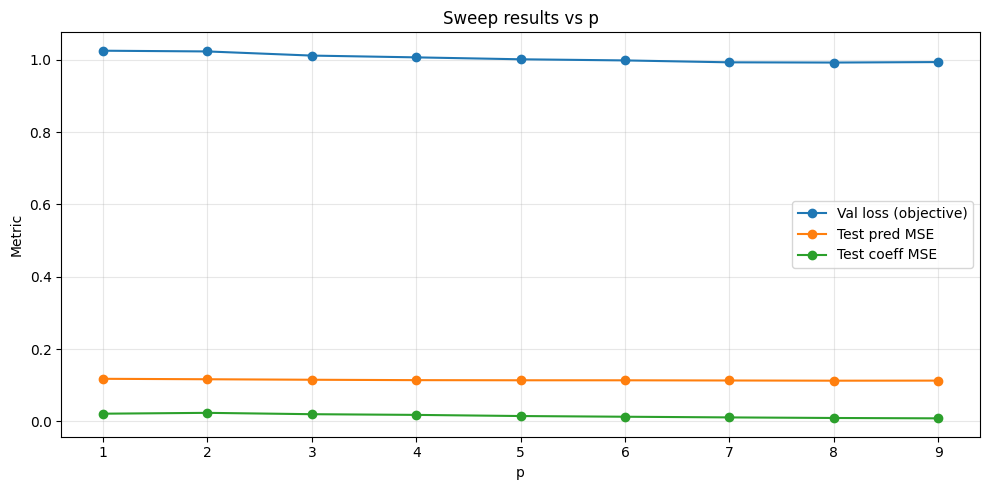

In [17]:
plot_mse_over_p(df)

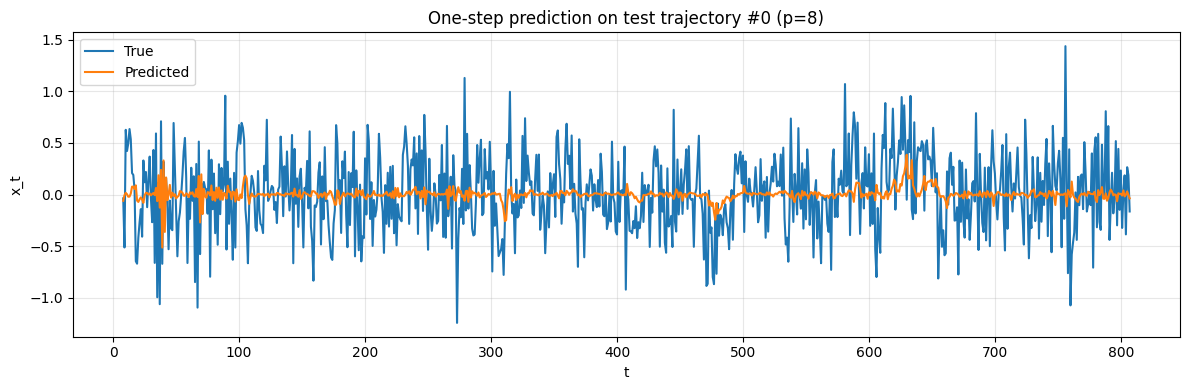

In [18]:
best_pack = out["best_pack"]
plot_pred_vs_true_signal(best_pack, test_ds, traj_index=0, max_points=800)

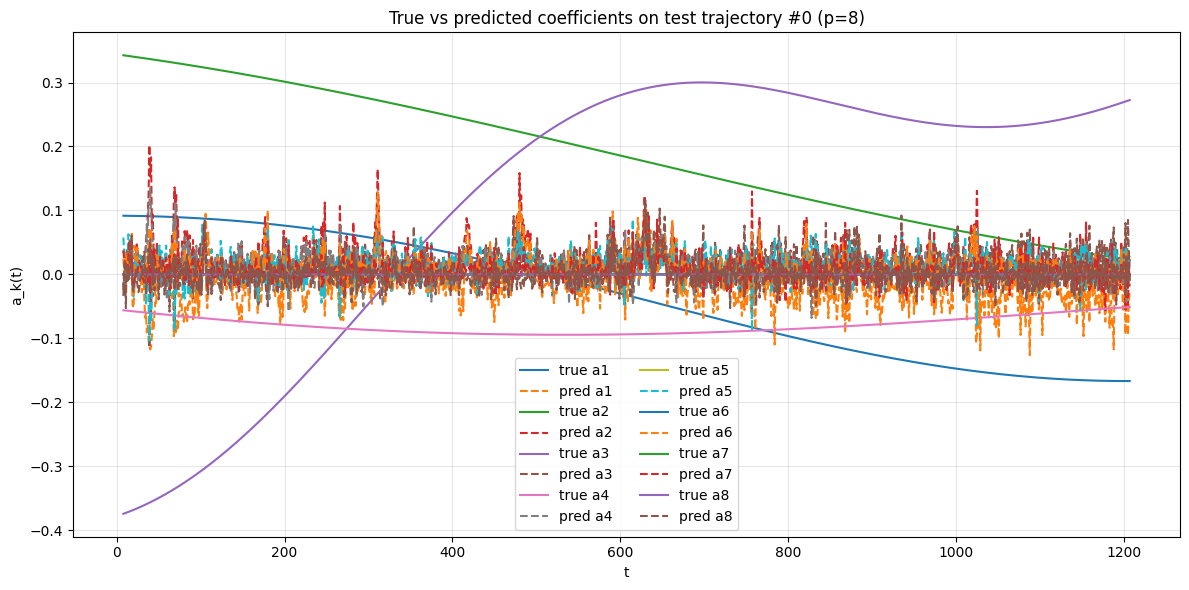

In [19]:
plot_coeff_trajectories(best_pack, test_ds, traj_index=0, max_points=1200)

In [20]:
p_list = list(range(1, 10))  # 1..9
packs = out["packs"]         # dict {p: trained pack}

p_hat_test, mse_mat_test = per_trajectory_phat(packs, test_ds, p_list)

print("p_hat (test):", p_hat_test)
print("p_true (test):", test_ds["p_true"])

p_hat (test): [8 8 8 7 8 9 8 7 1 8 5 8 3 1 6 8]
p_true (test): [4 4 4 2 4 6 4 4 1 4 6 2 1 1 2 2]
